In [2]:
#####import package ###
import os 
import sys
import numpy as np
import pandas as pd 
from pandas import DataFrame
import sklearn 
#import seaborn as sn 
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC,SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold,train_test_split,cross_val_score
from xgboost.sklearn import XGBClassifier 
from sklearn.metrics import confusion_matrix,matthews_corrcoef,accuracy_score,\
                            f1_score,recall_score,precision_score,roc_auc_score,roc_curve,auc
from sklearn.utils import shuffle  
from sklearn.metrics import matthews_corrcoef,make_scorer,confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [44]:
print(os.getcwd())
##########get data import ###
## train_data

####feature list (clinical and SNP )
def load_data():
    data_train = pd.read_csv("./data_1024/final_split/train_data.csv",sep = ",")
    data_train = shuffle(data_train,random_state = 42)
    train_data = data[['sex', 'age', 'smoke', 'bmi',"location", 'rs10007052', 'rs8192288', 'rs20541', 'rs12922394', 'rs2910164', 'rs161976', 'rs473892', 'rs159497', 'rs9296092']]
    #train_data = data_train[['sex', 'age','smoke','bmi', 'location']]
    #train_data = data[['rs10007052', 'rs8192288', 'rs20541', 'rs12922394', 'rs2910164', 'rs161976', 'rs473892', 'rs159497', 'rs9296092']]
    y_true =  data_train['label']
    return train_data,y_true
def load_testdata():
    data_test = pd.read_csv("./data_1024/final_split/test_data.csv",sep = ",")
    data_test = shuffle(data_test,random_state = 42)#
    test_data = data_test[['sex','age', 'smoke',"bmi","location", 'rs10007052', 'rs8192288', 'rs20541', 'rs12922394', 'rs2910164', 'rs161976', 'rs473892', 'rs159497', 'rs9296092']]
    #test_data = data_test[['sex','age', 'smoke',"bmi","location"]]
    #test_data = data_test[['rs10007052', 'rs8192288', 'rs20541', 'rs12922394', 'rs2910164', 'rs161976', 'rs473892', 'rs159497', 'rs9296092']]
    y_true = data_test["label"]
    return test_data,y_true    
#pos_weight = data_test['label'].value_counts()[0]/data_test['label'].value_counts()[1]
pos_weight = 0.08
####### list classify model with default parameter ###
knn = KNeighborsClassifier()
svm = SVC(probability=True,random_state=42)
lr = LogisticRegression(random_state=42,penalty='l1',C=10,max_iter=50,intercept_scaling=10)
tree = DecisionTreeClassifier()
nn = MLPClassifier(hidden_layer_sizes=(4,4,4),random_state = 42)
xgboost = xgb.XGBClassifier(scale_pos_weight=pos_weight,random_state=42,learning_rate=0.05,n_estimators=5000,max_depth = 500,reg_alpha=0.25,subsample=1,eval_metric="auc")
#xgboost = xgb.XGBClassifier()
classifier_lst = [knn, lr, svm, tree, nn,xgboost]
classifier_lst_name = ['KNN', 'LR', 'SVM', 'DT', 'MLP','XGboost']
###########
### add the new evalation parameter 

def npv_score(y_true,y_pred):
    confu = confusion_matrix(y_true,y_pred)
    print(confu)
    tn, fp, fn, tp = confu.ravel()
    
    NPV = tn/(tn+fn)
    print(NPV)
    return NPV

def spc_score(y_true,y_pred):
    confu = confusion_matrix(y_true,y_pred)
    #print(confu,confu.sum())
    tn, fp, fn, tp = confu.ravel()
    TNR = tn/(tn+fp)
    #print(TNR)
    return TNR 
#####

def make_baseline(data,classifier):
    X_train,y_train = load_data()
    X_test,y_test = load_testdata()
    
    classifier.fit(X_train,y_train)
    pred_proba = classifier.predict_proba(X_test)
    pred = classifier.predict(X_test)
    
    acc = accuracy_score(y_test,pred)
    precisions = precision_score(y_test,pred)
    recalls = recall_score(y_test,pred)
    f1s = f1_score(y_test,pred)
    mcc = matthews_corrcoef(y_test,pred)
    
    spc_value = spc_score(y_test,pred)
    npv_value = npv_score(y_test,pred)
    aucs1 = roc_auc_score(y_test,pred)
    fpr, tpr, thresholds = roc_curve(y_test, pred_proba[:, 1]) #,pos_label=1
    aucs = auc(fpr, tpr)
    print(aucs1,aucs)

    return acc,precisions,recalls,f1s,aucs,mcc,spc_value,npv_value
###### 计算各个模型的不同交叉验证指标
precisions_mean_lst =[]
recalls_mean_lst =[]
f1s_mean_lst,auc_mean_lst,acc_mean_lst = [],[],[]
mcc_mean_lst,spc_mean_lst,npv_mean_lst =[],[],[]
for i in classifier_lst:
    acc,precisions,recalls,f1s,aucs,mcc,spc,npv = make_baseline(data,i)
    acc_mean_lst.append(acc)
    precisions_mean_lst.append(precisions)
    recalls_mean_lst.append(recalls)
    f1s_mean_lst.append(f1s)
    auc_mean_lst.append(aucs)
    
    mcc_mean_lst.append(mcc)
    spc_mean_lst.append(spc)
    npv_mean_lst.append(npv)
    
    
print("acc:",acc_mean_lst)
print("precision:",precisions_mean_lst)
print("recalls:",recalls_mean_lst)
print("mcc",mcc_mean_lst)
print("f1_score:",f1s_mean_lst)
print("auc:",auc_mean_lst)
print("spc:",spc_mean_lst)
print("npv:",npv_mean_lst)
all_para = {"accuracy":acc_mean_lst,"precision":precisions_mean_lst,
            "recall":recalls_mean_lst,"f1score":f1s_mean_lst,
            "mcc_score":mcc_mean_lst,"aucscore":auc_mean_lst,
            "spc_score":spc_mean_lst,"npv_score":npv_mean_lst}
result = DataFrame(all_para,index = ['KNN', 'LR', 'SVM', 'DT', 'MLP','XGboost'])
print(result)
#result.to_csv("./result_1024/all_feature/allfeature_all_model_evaluation_index_validate.csv")# 所有特征结果保存
#result.to_csv("./result_1024/clincal/clinic_all_model_evaluation_index_validate.csv")# clinic特征结果保存
#result.to_csv("./result_1024/feature_snp/snp_all_model_evaluation_index_validate.csv")# snp特征结果保存

D:\Program File\Anaconda\Jupyter File\宝腾生物实习\10month_copd
[[ 10  79]
 [ 15 136]]
0.4
0.5065109011087136 0.47421683160949474
[[  1  88]
 [  5 146]]
0.16666666666666666
0.48906168613736145 0.47763970533521843
[[  0  89]
 [  0 151]]
nan
0.5 0.48165786144802436
[[ 24  65]
 [ 41 110]]
0.36923076923076925
0.49906987127018376 0.5022323089515588
[[  0  89]
 [  0 151]]
nan
0.5 0.5
[[51 38]
 [87 64]]
0.3695652173913043
0.4984373837339088 0.49103355904457174
acc: [0.6083333333333333, 0.6125, 0.6291666666666667, 0.5583333333333333, 0.6291666666666667, 0.4791666666666667]
precision: [0.6325581395348837, 0.6239316239316239, 0.6291666666666667, 0.6285714285714286, 0.6291666666666667, 0.6274509803921569]
recalls: [0.9006622516556292, 0.9668874172185431, 1.0, 0.7284768211920529, 1.0, 0.423841059602649]
mcc [0.02059042626053776, -0.06768310898309762, 0.0, -0.0020219984998159743, 0.0, -0.00305369870103865]
f1_score: [0.7431693989071039, 0.7584415584415585, 0.7723785166240409, 0.6748466257668712, 0.772378

# plot ROC Curve

In [45]:
feature,target = load_data()
X,y=np.array(feature),np.array(target)
print(X.shape,y.shape)
X_test,y_test = load_testdata()
X_test,y_test = np.array(X_test),np.array(y_test)
from sklearn.metrics import roc_curve, auc,roc_auc_score
from scipy import interp
import warnings
warnings.filterwarnings("ignore")

def plot_ROC(model,model_name):
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    fig=plt.gcf()
    fig.set_size_inches(8,5)

    probas_ = model.fit(X, y).predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1]) #,pos_label=1
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=3, alpha=0.8,
                 label='ROC validation %d (AUC = %0.2f)' % (i, roc_auc))

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    plt.xlim([-0.0, 1.0])
    plt.ylim([-0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{} model Receiver operating characteristic example'.format(model_name))
    plt.legend(loc="lower right")
    plt.show()

# 针对每个模型五折交叉验证绘制ROC曲线
for model,model_name in zip(classifier_lst,classifier_lst_name):
    plot_ROC(model,model_name)

(393, 9) (393,)


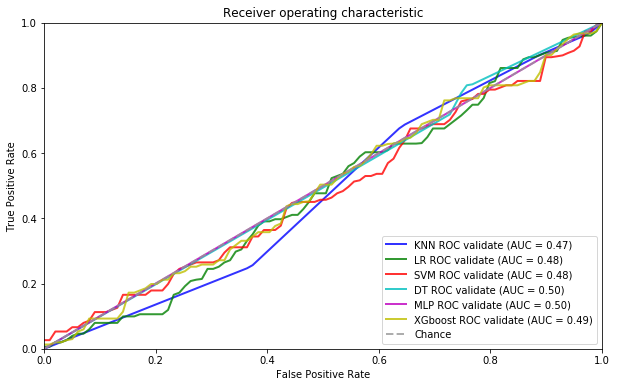

In [46]:
from sklearn.metrics import roc_curve, auc,roc_auc_score
from scipy import interp
import warnings
warnings.filterwarnings("ignore")

def plot_ROC(model,model_name,color):
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    probas_ = model.fit(X, y).predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1]) #,pos_label=1
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color=color,
             label=r'{} ROC validate (AUC = %0.2f)'.format(model_name) % (mean_auc),
             lw=2, alpha=.8)

color_list = ['b','g','r','c','m','y']
fig=plt.gcf()
fig.set_size_inches(10,6)
for model,model_name,color in zip(classifier_lst,classifier_lst_name,color_list):
    plot_ROC(model,model_name,color)
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color=(0.6, 0.6, 0.6),label='Chance', alpha=.8)
plt.xlim([-0.0, 1.0])
plt.ylim([-0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
fig.show()
#图表保存，分别对应选取的不同特征，全部特征，clinic特征和snp特征
#fig.savefig('result_1024/all_feature/all_feature_allModel_validate ROC curve_2.png',dpi=200)# 全部特征
#fig.savefig('result_1024/clincal/clinic_allModel_validate ROC curve_2.png',dpi=200)# clinic特征
#fig.savefig('result_1024/feature_snp/snp_allModel_validate ROC curve_2.png',dpi=200)# snp特征

In [ ]:
                     aucscore  spc_score  npv_score  
KNN                  0.795260   0.651685   0.794521  
Logistic_Regression  0.811370   0.584270   0.852459  
SVM                  0.775355   0.516854   0.836364  
DecisionTree         0.718394   0.483146   0.860000  
NeuralNetwork        0.780490   0.359551   1.000000  
XGboost              0.801287   0.573034   0.850000  

# plot PR Curve

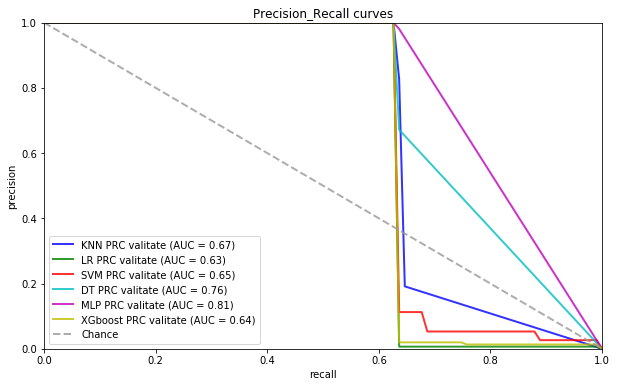

In [47]:
from sklearn.metrics import roc_curve, auc,roc_auc_score,precision_recall_curve
from scipy import interp
import warnings
warnings.filterwarnings("ignore")

def plot_ROC(model,model_name,color):
    recalls = []
    precisions = []
    aucspr = []
    mean_recall = np.linspace(0, 1, 100)

    probas_ = model.fit(X, y).predict_proba(X_test)
    precision, recall, thresholds = precision_recall_curve(y_test, probas_[:, 1])
    precisions.append(interp(mean_recall, precision,recall))
    pr_auc = auc(recall, precision)
    aucspr.append(pr_auc)
    
    mean_precision = np.mean(precisions,axis = 0)
    #print(mean_precision)
    mean_auc = auc(mean_recall, mean_precision)
    std_auc = np.std(aucspr)
    plt.plot(mean_recall, mean_precision, color=color,
             label=r'{} PRC valitate (AUC = %0.2f)'.format(model_name)% (mean_auc),
             lw=2, alpha=.8)

color_list = ['b','g','r','c','m','y']
fig=plt.gcf()
fig.set_size_inches(10,6)
for model,model_name,color in zip(classifier_lst,classifier_lst_name,color_list):
    plot_ROC(model,model_name,color)
    
x1 = np.linspace(0,1,100)
y1 = -1*x1+1
plt.plot(x1,y1, linestyle='--', lw=2, color=(0.6, 0.6, 0.6),label='Chance', alpha=.8)
plt.xlim([-0.0, 1.0])
plt.ylim([-0.0, 1.0])
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision_Recall curves')
plt.legend(loc="lower left")
fig.show()
#fig.savefig('result_1024/all_feature/allfeature_allModel_validation PR curve_2.png',dpi=200) # 全部特征
#fig.savefig('result_1024/clincal/clinic_allModel_validation PR curve_2.png',dpi=200)# clinic特征
#fig.savefig('result_1024/feature_snp/snp_allModel_validation PR curve_2.png',dpi=200)# snp特征